In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
data = pd.read_csv('/content/fer2013.csv')


In [6]:
data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


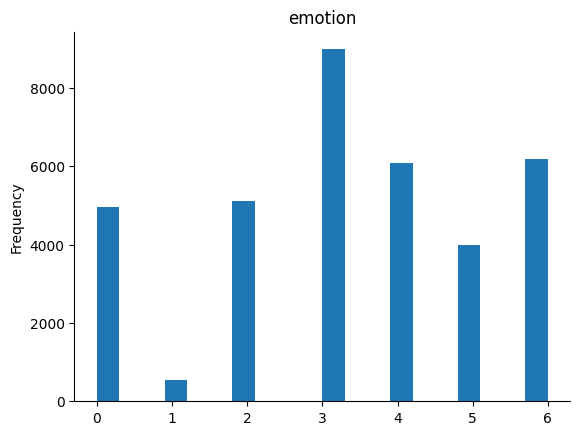

In [7]:
# @title emotion

from matplotlib import pyplot as plt
data['emotion'].plot(kind='hist', bins=20, title='emotion')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [8]:
data.shape


(35887, 3)

In [9]:
labels = data.iloc[:, 0]


In [10]:
pixels = data.iloc[:, 1]
images = np.zeros((pixels.shape[0], 48*48))
for ix in range(images.shape[0]):
    p = pixels[ix].split(' ')
    for iy in range(images.shape[1]):
        images[ix, iy] = int(p[iy])

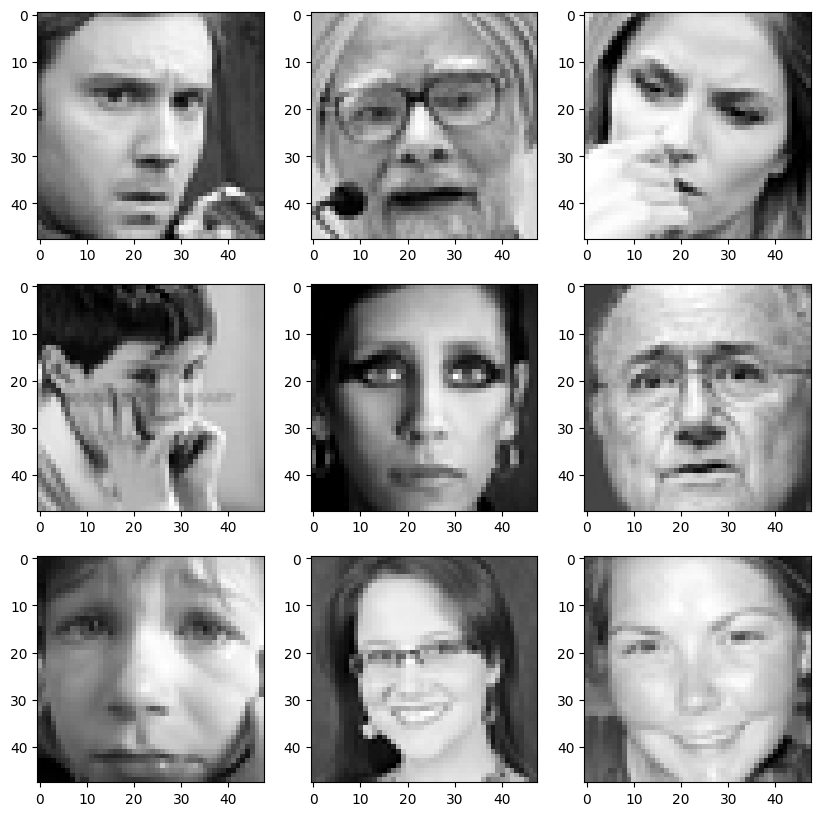

In [11]:
plt.figure(figsize = (10,10))
for index,image in enumerate(images[:9]):
    plt.subplot(3,3,index+1)
    plt.imshow(image.reshape((48,48)), cmap = 'gray')
plt.show()

In [12]:
train_or_test = data.iloc[:, 2].values
data["Usage"].unique()

array(['Training', 'PublicTest', 'PrivateTest'], dtype=object)

In [13]:
data['emotion'].unique()

array([0, 2, 4, 6, 3, 5, 1])

In [14]:
reshaped_images = np.zeros((images.shape[0], 48, 48,1))
i = 0
for image in images:
  reshaped_images[i] = image.reshape((48,48,1))
  i+=1

In [15]:
reshaped_images.shape


(35887, 48, 48, 1)

In [16]:
norm_images = reshaped_images / 255.0


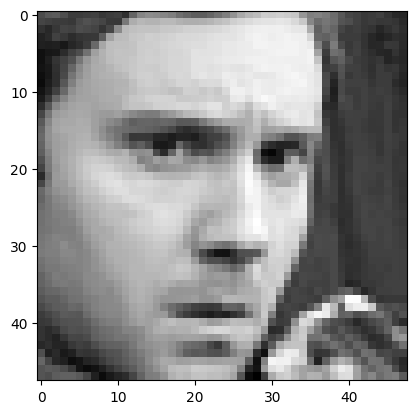

In [17]:
plt.imshow(norm_images[0].reshape((48,48)), cmap="gray")
plt.show()

In [18]:
from tensorflow.keras.utils import to_categorical


In [19]:
new_labels = to_categorical(labels, num_classes=7)
new_labels.shape

(35887, 7)

In [20]:
reshaped_images.shape

(35887, 48, 48, 1)

In [21]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(norm_images, new_labels, test_size=0.2, random_state = 42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((28709, 48, 48, 1), (7178, 48, 48, 1), (28709, 7), (7178, 7))

In [22]:
import tensorflow as tf
tf.__version__

'2.15.0'

In [23]:
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

In [24]:
model = Sequential()

model.add(Conv2D(64, (3,3), padding = "same", input_shape = (48,48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (5,5), padding = "same"))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(512, (3,3), padding = "same"))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(512, (3,3), padding = "same"))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(7, activation = "softmax"))


In [25]:
opt = Adam(learning_rate = 0.0005)

model.compile(optimizer = opt, loss = "categorical_crossentropy", metrics = ['accuracy'])

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (Batch  (None, 48, 48, 64)        256       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 128)       2

In [27]:
epochs = 5

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=2, min_lr=0.00001, mode='auto')

checkpoint = ModelCheckpoint("fer_model.h5", monitor='val_loss',
                             mode='max', verbose=1)

callbacks = [checkpoint, reduce_lr]

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), callbacks=callbacks, epochs = epochs)

Epoch 1/5
898/898 [==============================] - ETA: 0s - loss: 1.7756 - accuracy: 0.3240
Epoch 1: saving model to fer_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


898/898 [==============================] - 33s 25ms/step - loss: 1.7756 - accuracy: 0.3240 - val_loss: 1.8271 - val_accuracy: 0.3070 - lr: 5.0000e-04
Epoch 2/5
897/898 [============================>.] - ETA: 0s - loss: 1.4343 - accuracy: 0.4521
Epoch 2: saving model to fer_model.h5
898/898 [==============================] - 20s 23ms/step - loss: 1.4344 - accuracy: 0.4521 - val_loss: 1.5918 - val_accuracy: 0.4157 - lr: 5.0000e-04
Epoch 3/5
897/898 [============================>.] - ETA: 0s - loss: 1.2872 - accuracy: 0.5093
Epoch 3: saving model to fer_model.h5
898/898 [==============================] - 21s 23ms/step - loss: 1.2873 - accuracy: 0.5093 - val_loss: 1.2163 - val_accuracy: 0.5350 - lr: 5.0000e-04
Epoch 4/5
898/898 [==============================] - ETA: 0s - loss: 1.2106 - accuracy: 0.5386
Epoch 4: saving model to fer_model.h5
898/898 [==============================] - 21s 24ms/step - loss: 1.2106 - accuracy: 0.5386 - val_loss: 1.2027 - val_accuracy: 0.5428 - lr: 5.0000e-04
E

In [28]:
emotions = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')

In [29]:
import PIL
from PIL import Image

In [30]:
import cv2

In [41]:

img = cv2.imread("/content/angryy.jpg")


In [42]:
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


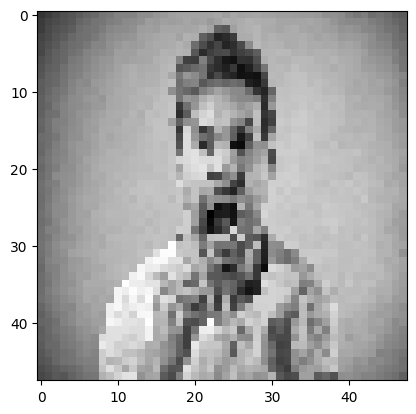

In [43]:
img.shape


img = cv2.resize(img, (48,48))
plt.imshow(img, cmap='gray')

In [44]:
np.argmax(model.predict(img.reshape((1,48,48,1))), axis=-1)[0]


1/1 [==============================] - 0s 30ms/step


3

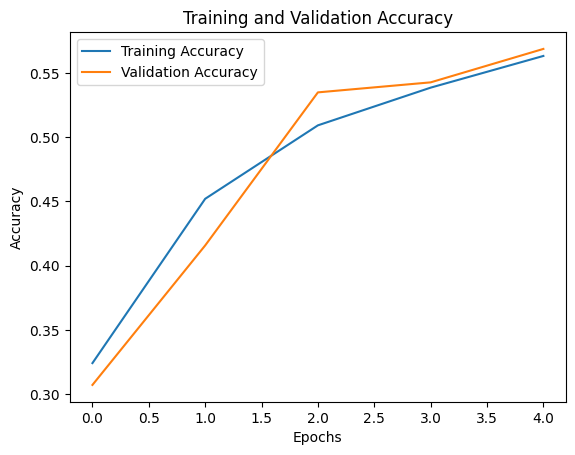

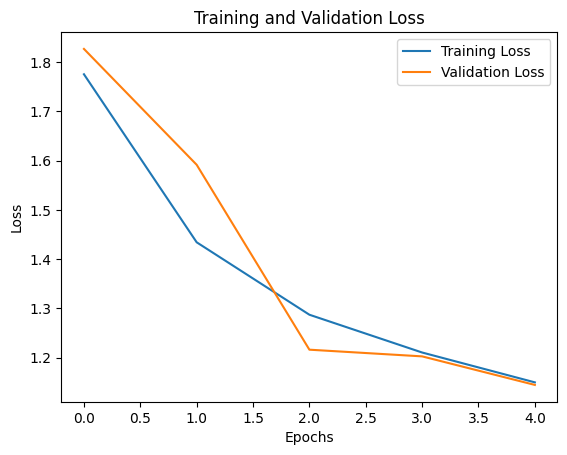

In [35]:
# Visualize training and validation accuracy/loss curves
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [36]:
model.save("Fer_Model.h5")
model.save_weights("model_weights.h5")
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)